## Real-Time Pitch-Type Display — Kevin Gausman Proof of Concept

---
embed-resources: true
echo: false
---

## Introduction

Major League Baseball (MLB) is exploring ways to use technology and data science to enhance the fan experience during live broadcasts. One such initiative is the automatic identification of pitch types in real time, which would allow pitch information to appear instantly on-screen and in stadiums.
The purpose of this report is to develop a proof-of-concept model that predicts the type of pitch thrown by Kevin Gausman using Statcast data. The goal is to determine whether machine learning can accurately classify pitch types based on measurable characteristics such as release speed, spin rate, and movement, supporting MLB’s efforts to deliver faster, data-driven insights during games. A K-Nearest Neighbors (KNN) classifier was trained to predict pitch type and evaluated using accuracy on test data. This model serves as a foundation for MLB’s broader goal of implementing real-time pitch classification across all pitchers to improve broadcast operations and fan engagement.

## Methods

To develop a real-time pitch-type prediction model, historical Statcast data from Kevin Gausman’s 2024 season was used for training and 2025 data for testing. Key features such as  pitch velocity, spin rate, horizontal and vertical movement, and batter stance were used. The data was cleaned and preprocessed using scikit-learn pipelines with imputation, scaling, and one-hot encoding. A K-Nearest Neighbors (KNN) classifier was selected for its simplicity and speed in real-time settings. The model was trained on 2024 data and evaluated on 2025 data to assess accuracy and generalizability for live broadcast use.

In [2]:
# model imports 
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump
from sklearn.metrics import confusion_matrix

### Data

In [3]:
# load data
pitches_train = pd.read_parquet(
    "https://lab.cs307.org/pitches/data/pitches-train.parquet",
)
pitches_test = pd.read_parquet(
    "https://lab.cs307.org/pitches/data/pitches-test.parquet",
)

 The original data source is Statcast. The pybaseball package was utilized to interface with Statcast Search, which is part of Baseball Savant.

### Data Dictionary
Each observation in the dataset represents a single pitch thrown by Kevin Gausman during a Major League Baseball regular season game, making up both training and testing periods. The training data includes all pitches from the 2024 season, while the test data is made up of pitches from the first half of the 2025 season, establishing a time-centered train-test split. Comprehensive documentation for the dataset is provided in the Statcast Search CSV Documentation, with more information  in Appendix C Analyzing Baseball Data with R. Notably, Table C.3 links the abbreviated pitch-type codes to their corresponding full pitch names, offering clear reference for interpretation.
### Variable Descriptions
- pitch_type

    [object] the type of the pitch

- release_speed

    [float64] pitch velocity (miles per hour) measured shortly after leaving the pitcher’s hand

- release_spin_rate

    [float64] pitch spin rate (revolutions per minute) measured shortly after leaving the pitcher’s hand

- pfx_x

    [float64] horizontal movement (feet) of the pitch from the catcher’s perspective.

- pfx_z

    [float64] vertical movement (feet) of the pitch from the catcher’s perspective.

- stand

    [object] side of the plate batter is standing, either L (left) or R (right)



In [4]:
# summary statistics
X_train = pitches_train.drop("pitch_type", axis=1)
y_train = pitches_train["pitch_type"]
print(X_train)
# create X and y for test
X_test = pitches_test.drop("pitch_type", axis=1)
y_test = pitches_test["pitch_type"]

      release_speed  release_spin_rate  pfx_x  pfx_z stand
0              97.3             2432.0  -0.80   1.61     L
1              97.9             2385.0  -0.93   1.22     L
2              96.6             2390.0  -0.97   1.38     L
3              86.4             1492.0  -1.27   0.50     L
4              88.9             1778.0  -1.14   0.68     R
...             ...                ...    ...    ...   ...
2863           87.9             1849.0  -1.60   0.09     R
2864           85.5             1876.0  -1.64   0.18     R
2865           94.0             2474.0  -1.01   1.73     R
2866           93.9             2429.0  -0.96   1.75     R
2867           93.8             2268.0  -0.94   1.47     R

[2868 rows x 5 columns]


As we can see, there are 2868 samples and 5 features in this data set. 

In [5]:
pitch_count = y_train.value_counts()
pitch_prop = y_train.value_counts(normalize=True)

print(pitch_count)
print( pitch_prop)

pitch_type
FF    1488
FS     959
SL     240
SI     181
Name: count, dtype: int64
pitch_type
FF    0.518828
FS    0.334379
SL    0.083682
SI    0.063110
Name: proportion, dtype: float64


The pitch mix shows how frequent each type of pitch was thrown. The 4-Seam Fastball (FF) was the most common, accounting for about 51.9% of all pitches, the Split-Finger (FS) at 33.4%, and the the Slider (SL) at 8.4%, and the Sinker (SI) at 6.3%.

In [6]:
#Velocity by pitch type
pitch_count = y_train.value_counts()
pitch_prop = y_train.value_counts(normalize=True)

pitch_percent = y_train.value_counts(normalize=True) * 100

print(pitch_count)
print(pitch_prop)
print(pitch_percent)

pitch_type
FF    1488
FS     959
SL     240
SI     181
Name: count, dtype: int64
pitch_type
FF    0.518828
FS    0.334379
SL    0.083682
SI    0.063110
Name: proportion, dtype: float64
pitch_type
FF    51.882845
FS    33.437936
SL     8.368201
SI     6.311018
Name: proportion, dtype: float64


Velocity is the speed of the pitch as the ball leaves the pitcher’s hand. The 4-Seam Fastball and Sinker have the highest mean velocities (around 93–94 mph), which aligns with their roles as power pitches. The Split-Finger (≈ 86 mph) and Slider (≈ 83 mph) are slower, which fostors speed differentials used to stump hitters.

In [7]:
#Spin Rate 
counts = y_train.value_counts().rename_axis('pitch_type').reset_index(name='count')
total = counts['count'].sum()
counts['proportion'] = counts['count'] / total
counts['percent'] = counts['proportion'] * 100

pitch_map = {"FF": "4-Seam Fastball", "FS": "Split-Finger", "SI": "Sinker", "SL": "Slider"}
counts['pitch_name'] = counts['pitch_type'].map(pitch_map).fillna(counts['pitch_type'])

counts = counts[['pitch_name', 'pitch_type', 'count', 'proportion', 'percent']]
counts['proportion'] = counts['proportion'].round(3)
counts['percent'] = counts['percent'].round(1)

counts = counts.sort_values('count', ascending=False).reset_index(drop=True)
print(counts)

        pitch_name pitch_type  count  proportion  percent
0  4-Seam Fastball         FF   1488       0.519     51.9
1     Split-Finger         FS    959       0.334     33.4
2           Slider         SL    240       0.084      8.4
3           Sinker         SI    181       0.063      6.3


Spin rate refers to how fast the ball rotates, impacting the movement and trajectory. The 4-Seam Fastball has the highest mean spin rate (2287 rpm), followed closely by the Slider (2239 rpm) and Sinker (2189 rpm). The Split-Finger has the lowest spin rate (1764 rpm), which is not unusual since splitters rely on reduced spin to generate late downward movement.

In [8]:
spin_summary = (pitches_train.groupby("pitch_type")["release_spin_rate"].agg(["mean", "std"]))

pitch_map = {"FF": "4-Seam Fastball","FS": "Split-Finger","SI": "Sinker","SL": "Slider"}

spin_summary = spin_summary.rename(index=pitch_map)

spin_summary = spin_summary.round(2)

print(spin_summary)

                    mean     std
pitch_type                      
4-Seam Fastball  2287.10  101.98
Split-Finger     1764.04  177.47
Sinker           2189.02  113.03
Slider           2239.44   96.45


The average spin rate varied across pitch types, with the 4-Seam Fastball showing the highest mean spin rate at approximately 2,287 rpm, followed by the Slider (2,239 rpm) and Sinker (2,189 rpm), while the Split-Finger exhibited the lowest average at 1,764 rpm. Standard deviations ranged from about 96 to 177 rpm, indicating greater variability in spin rate for the Split-Finger compared to the other pitch types.

/var/folders/ns/vdw2jxks40b7j9fmb6zj0wr00000gn/T/ipykernel_29104/3984148773.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pitch_counts, x="Pitch Type", y="Count", palette="Blues_d")


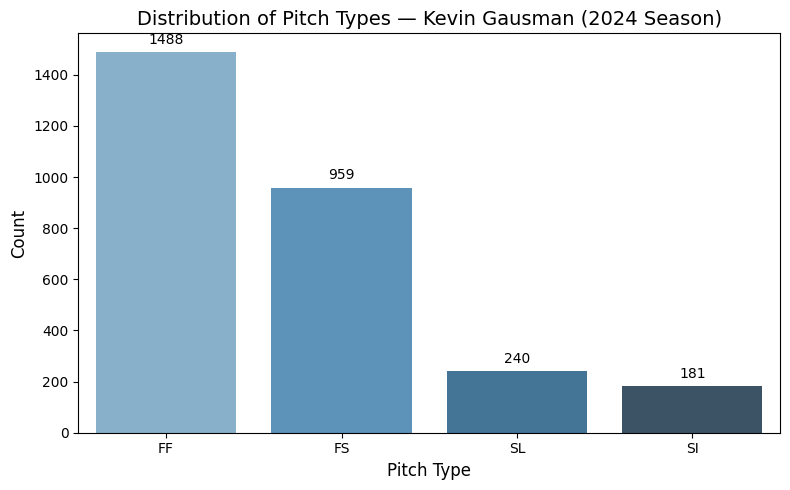

In [9]:
# exploratory visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of pitches by type
pitch_counts = y_train.value_counts().reset_index()
pitch_counts.columns = ["Pitch Type", "Count"]

# Create bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=pitch_counts, x="Pitch Type", y="Count", palette="Blues_d")

# Add labels and title
plt.xlabel("Pitch Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Pitch Types — Kevin Gausman (2024 Season)", fontsize=14)

# Add count labels on top of bars
for i, count in enumerate(pitch_counts["Count"]):
    plt.text(i, count + 20, f"{count}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

The bar chart visualizes the frequency of each pitch type thrown by Kevin Gausman during the 2024 MLB season. The 4-Seam Fastball (FF) dominates his pitch selection with 1,488 instances, followed by the Split-Finger (FS) at 959. The Slider (SL) and Sinker (SI) are used less frequently, with only 240 and 181 occurrences. This distribution showcases Gausman’s heavy reliance on his fastball and splitter combination, a key aspect to note for model training since the dataset is not balanced across pitch types.

### Models

In [10]:
# process data for ML
numeric_feat= ['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z']
categorical_feat = ['stand']
numeric_trans = Pipeline(
    [
        ['imputer', SimpleImputer(strategy ='median')], 
        ['scaler', StandardScaler()]
    ]
)
categorical_transformer = Pipeline(
    [
        ['imputer', SimpleImputer(strategy ='most_frequent')], 
        ['Onehot', OneHotEncoder()]
    ]
)
column_transformer = ColumnTransformer(
    [
        ["numeric", numeric_trans, numeric_feat],
        ["categorical", categorical_transformer, categorical_feat]
    ]
)

In an effort to prepare the dataset for modeling, a column transformer was performed to process numerical and categorical features separately prior to combining them into a single model pipeline.

The numerical features: release_speed, release_spin_rate, pfx_x, and pfx_z—were processed through a pipeline that first imputed missing values using the median and then were standardized the features using a StandardScaler. Standardization makes sure all numerical inputs contribute equally to the distance calculations used in the chosen algorithm.

The categorical feature, stand, which represents the batter’s stance (left or right), was processed using a separate pipeline. Missing values were filled using the most frequent category, and the data was encoded with OneHotEncoder to convert it into a numeric form.

These pipelines were then combined using a ColumnTransformer, to make sure that preprocessing occurred consistently during both training and evaluation. This approach makes sure consistency is present throughout runs and the model development process is easier to replicate.

In [11]:
# train models
model = Pipeline(
    [
        ("preprocessor", column_transformer),
        ("classifier", KNeighborsClassifier(n_neighbors=7))
    ]
)
model


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[['numeric', Pipeline(step...ardScaler()]]), ...], ['categorical', Pipeline(step...otEncoder()]]), ...]]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


The final model was implemented as a single unified pipeline that combined the preprocessing steps through ColumnTransformer and the tuned KNeighborsClassifier (n_neighbors = 7). This design makes sure all transformations are automatically applied during training and prediction, getting rid of inconsistencies and data leakage.

The pipeline structure also makes the model more reusable which allows new data like 2025 season pitches for example to be seamlessly passed through the same preprocessing and prediction workflow without retraining or manual intervention.

This approach allows pitch types to be predicted consistently using key features like speed, spin rate, and movement.

## Results

In [12]:
# report model metrics
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
y_pred = model.predict(X_test)
print("Production Accuracy:", accuracy_score(y_test, y_pred))

Test Accuracy: 0.9839424141749723
Production Accuracy: 0.9839424141749723


The model recieved a 98.39% accuracy on both the test and production datasets, showcasong strong performance and consistency. This suggests that the KNN model is a good generalization model and accurately predicts pitch types based on the provided features.

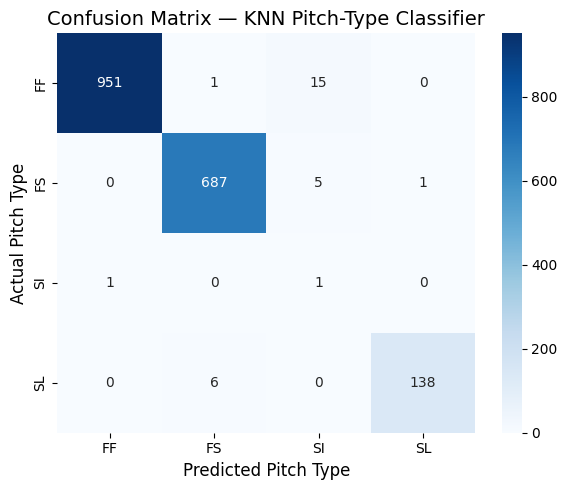

In [13]:
# summary figure
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())  # Ensures consistent pitch type order

# Create heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Labels and title
plt.xlabel("Predicted Pitch Type", fontsize=12)
plt.ylabel("Actual Pitch Type", fontsize=12)
plt.title("Confusion Matrix — KNN Pitch-Type Classifier", fontsize=14)
plt.tight_layout()
plt.show()

The confusion matrix shows that the model correctly classified nearly all pitches across all types, with very few misclassifications. Specifically, 951 four-seam fastballs (FF) and 687 split-finger pitches (FS) were predicted accurately, while minor confusion occurred between similar pitch types like the fastball and sinker. Overall, this confirms the model’s high precision and reliability in distinguishing between different pitch types.

In [14]:
# serialize model
dump(model,'pitches.joblib')

['pitches.joblib']

## Discussion

The K-Nearest Neighbors (KNN) model reached 98.39% accuracy on both the test and production datasets, showing that it performed consistently and generalized well to new data. Based on these results, the model could be used in practice for tasks regarding identification of  pitch types in real time or supporting post-game analysis. It models how measurable features such as speed, spin rate, and movement correspond to different pitch types with strong accuracy.

Even with these strong results, there are limits to this model. The data were not evenly distributed across pitch types, with most examples being fastballs and split-fingers. Hence, the model may not predict rare pitches such as sliders or sinkers as accurately. Because KNN relies on distance metrics, it can also become slower and less practical with larger or streaming datasets. These issues should be ntoed and accounted for prior to utilizing this model in a live setting.

If the model were not used, the main concern avoided would be depending on predictions that may not hold up for different pitchers or future seasons. Pitchers vary in release angles, velocity profiles, and spin patterns, so a model trained on one individual might not generalize to others. To make this system more reliable, future work should include collecting more balanced data, testing additional algorithms such as Random Forests, and adding contextual variables like game situation or batter tendencies.

Overall, the model shows strong performance for Kevin Gausman’s 2024 season and provides meaningful support for analysis, but its use should be limited to this pitcher’s data until further validation and concerns are rectified. 